In [ ]:
# Configuration OpenMP
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Imports des modules locaux
from data_loading import *
from models import *
from training import *
from visualization import *
from evaluation import *

print("✓ Modules rechargés avec succès")


TypeError: 'type' object is not subscriptable

### Env configuration

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Data path configuration
project_root = Path(os.getcwd()).parent.parent  # go back from modular -> NFTM_for_Physic -> NFTM
data_dir = project_root / "Data"
print(f"Data directory: {data_dir}")

models_dir = project_root /"NFTM_for_Physic"/ "saved_models"

# Check file existence
files_burger = {
    0.001: data_dir / "burgers1D_training_data_Nu0.001.npz",
    0.01:  data_dir / "burgers1D_training_data_Nu0.01.npz",
    0.1:   data_dir / "burgers1D_training_data_Nu0.1.npz",
    0.5:   data_dir / "burgers1D_training_data_Nu0.5.npz",
}

print("\nAvailable data files:")
for nu, filepath in files_burger.items():
    exists = "✓" if filepath.exists() else "✗"
    print(f"  {exists} Nu={nu}: {filepath.name}")

Device used: cuda
Data directory: c:\Dev\CentralSupelec\BDRP\NFTM\Data

Available data files:
  ✓ Nu=0.001: burgers1D_training_data_Nu0.001.npz
  ✓ Nu=0.01: burgers1D_training_data_Nu0.01.npz
  ✓ Nu=0.1: burgers1D_training_data_Nu0.1.npz
  ✓ Nu=0.5: burgers1D_training_data_Nu0.5.npz


### Dataset Configuration and Loading

In [5]:
# ========== DATASET CONFIGURATION ==========
# Change this parameter to switch between datasets:
# - "simple": Uses BurgersDatasetSimple (one trajectory per viscosity from Data/ folder)
# - "generated": Uses BurgersViscosityDataset (multiple samples from generated_1d_burgers/ folder)

DATASET_TYPE = "generated"  # Change to "generated" to use the other dataset

batch_size = 4
history_len = 3  # Only used for "generated" dataset

# ========== DATASET LOADING ==========
if DATASET_TYPE == "simple":
    print("📁 Using BurgersDatasetSimple with Data/ folder files")
    train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
    test_loader = None  # No test split for simple dataset
    
elif DATASET_TYPE == "generated":
    print("📁 Using BurgersViscosityDataset with generated samples")
    # Path to your generated samples folder
    generated_data_dir = project_root / "NFTM_for_Physic" / "generated_1d_burgers"
    
    if not generated_data_dir.exists():
        print(f"❌ Generated data directory not found: {generated_data_dir}")
        print("Creating a fallback to simple dataset...")
        DATASET_TYPE = "simple"
        train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
        test_loader = None
    else:
        try:
            train_loader, test_loader = create_generated_dataloaders(
                root_dir=str(generated_data_dir),
                history_len=history_len,
                batch_size=batch_size,
                train_ratio=0.8
            )
            print(f"✓ Generated dataset loaded from: {generated_data_dir}")
            print(f"✓ Train/test split created with ratio 0.8")
        except Exception as e:
            print(f"❌ Error loading generated dataset: {e}")
            print("Falling back to simple dataset...")
            DATASET_TYPE = "simple"
            train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
            test_loader = None

else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Use 'simple' or 'generated'")

📁 Using BurgersViscosityDataset with generated samples
✓ Generated dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers
✓ Train/test split created with ratio 0.8


Sample 391 | nu=0.1000
 initial_field: torch.Size([128])
 trajectory   : torch.Size([256, 128])


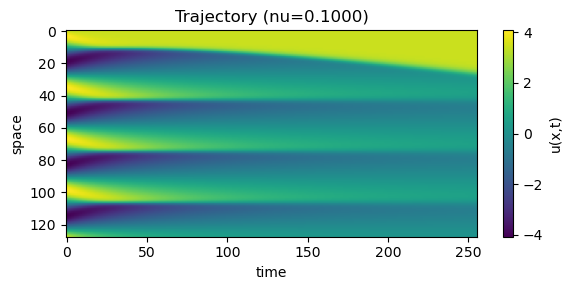

In [6]:
if DATASET_TYPE == "simple":
    # For simple dataset, show sample from the raw dataset
    dataset = train_loader.dataset
    idx = np.random.randint(0, len(dataset))
    show_random_sample(dataset, idx)
elif DATASET_TYPE == "generated":
    # For generated dataset, show sample from the training set
    dataset = train_loader.dataset
    if hasattr(dataset, 'dataset'):  # Handle random_split wrapper
        dataset = dataset.dataset
    idx = np.random.randint(0, len(dataset))
    show_random_sample(dataset, idx)

### Load model

In [ ]:
# Model configuration
patch_radius = 1
patch_size = 2 * patch_radius + 1
chunk_size = 5

LOAD_MODEL_NAME = None

# --- CNN Model --- #
# model = CNNControllerPatch(patch_size=patch_size)

# --- RNN Model  --- #
model = RNNControllerPatch(patch_size=patch_size)

# --- CNN Model with time history --- #
# model = CNNControllerHistory(patch_size=patch_size, hidden_size=64)

# --- CNN Model with space-time convolution --- #
model = CNNSpaceTimeController(
    patch_size=patch_size,
    hidden_channels=64,
    kernel_t=3,   # <=  chunk_size, sinon dim temps du kernel sera plus grande que L
    kernel_x=3,
).to(device)


# --- Load a saved model # 
# LOAD_MODEL_NAME = "CNN.pth"  # Set to filename like "my_model.pth" to load a model


if LOAD_MODEL_NAME is not None:
    print(f"📥 Loading model from: {LOAD_MODEL_NAME}")
    model = torch.load(models_dir / LOAD_MODEL_NAME, map_location=device, weights_only=False)
    print(f"✓ Model loaded successfully")
else:
    # Create new model if not loading
    model = CNNControllerHistory(patch_size=patch_size, hidden_size=64)
    print("🆕 Created new model")

model = model.to(device)

print(f"Model information:")
print(f"  - Patch radius: {patch_radius}")
print(f"  - Patch size: {patch_size}")
print(f"  - Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

🆕 Created new model
Model information:
  - Patch radius: 1
  - Patch size: 3
  - Number of parameters: 8770

Model architecture:
CNNControllerHistory(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (attn): Linear(in_features=64, out_features=1, bias=True)
  (fc_out): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Model training

In [ ]:
num_epochs = 1

print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

# Select appropriate training function based on model type
print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

train_losses, training_mode = train_model_auto(
    model=model,
    dataloader=train_loader,
    device=device,
    patch_radius=patch_radius,
    num_epochs=num_epochs,
    chunk_size=chunk_size,   # utilisé seulement pour les modèles séquentiels
)

print(f"\n Training completed!")
print(f" Dataset used : {DATASET_TYPE}")
print(f" Model        : {model.__class__.__name__}")
print(f" Mode         : {training_mode}")
print(f" Final loss   : {train_losses[-1]:.6f}")

🚀 Starting training for 1 epochs with generated dataset...
🚀 Starting training for 1 epochs with generated dataset...


### Loss funciton

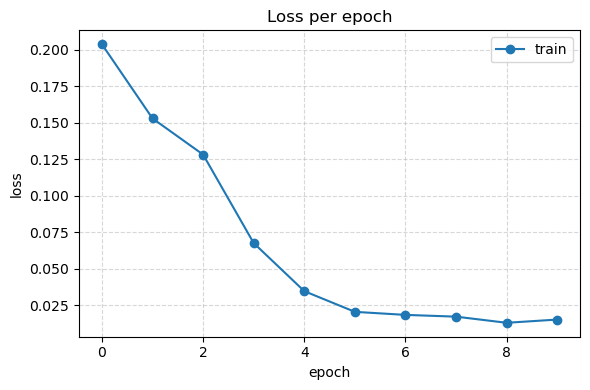

Final loss: 0.015238
Loss reduction: 92.52%


In [ ]:
plot_losses(train_losses)

print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

### Generate prediction

### Visualization

Generating predictions for nu = 0.1000
True trajectory shape: torch.Size([256, 128])
Model type: CNNSpaceTimeController
Sequential mode: 251 prédictions avec chunk_size=5
  step 0/251
  step 10/251
  step 20/251
  step 30/251
  step 40/251
  step 50/251
  step 60/251
  step 70/251
  step 80/251
  step 90/251
  step 100/251
  step 110/251
  step 120/251
  step 130/251
  step 140/251
  step 150/251
  step 160/251
  step 170/251
  step 180/251
  step 190/251
  step 200/251
  step 210/251
  step 220/251
  step 230/251
  step 240/251
  step 250/251

Generated predictions shape: torch.Size([256, 128])


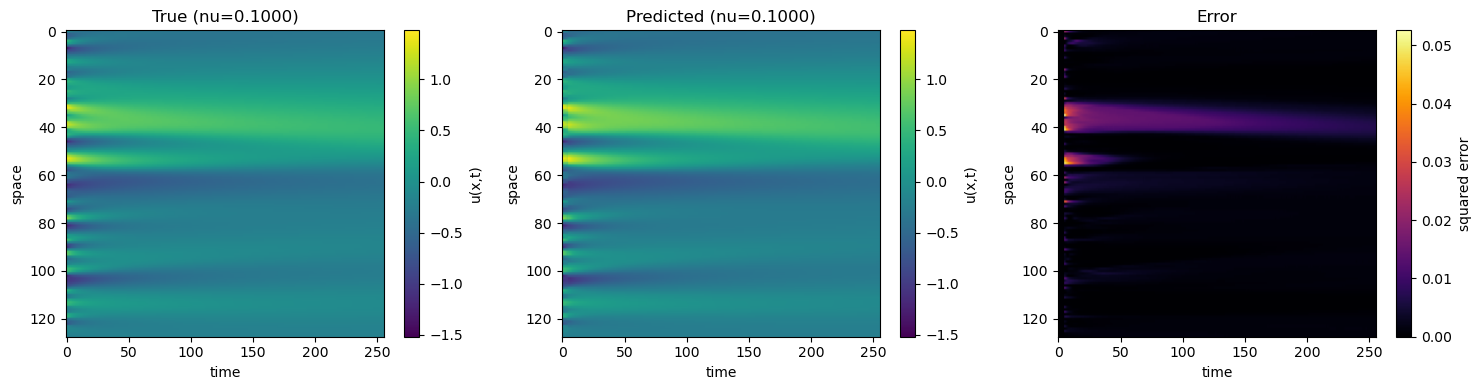

In [ ]:
# Generate predictions for visualization
true_traj, pred_traj, nu_value = generate_model_predictions(
    model, 
    train_loader, 
    device, 
    patch_radius, 
    verbose=True, 
    chunk_size=chunk_size
)

# Visualize trajectories
plot_trajectories(true_traj, pred_traj, title_suffix=f" (nu={nu_value:.4f})")

### Evaluation

Evaluation metrics:
  - PSNR: 26.262 dB
  - SSIM: 0.871
  - MSE: 0.002365
  - R²: 0.9544


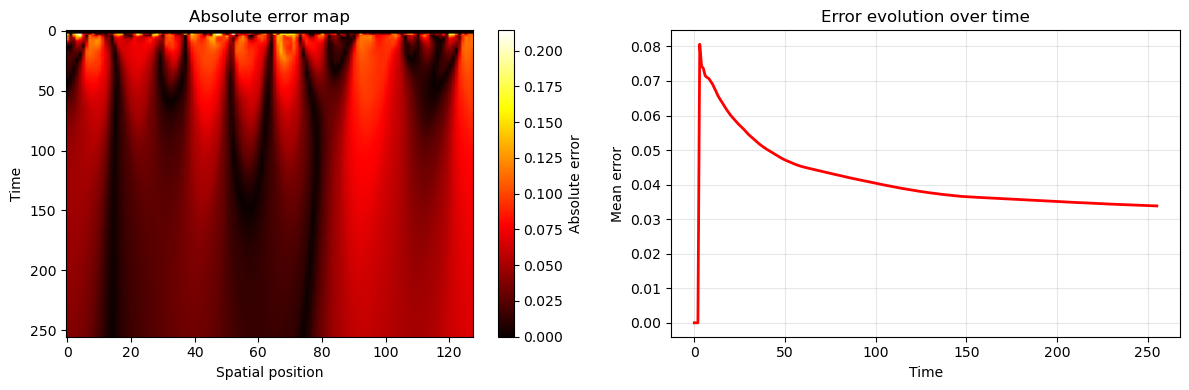

In [ ]:
# Complete evaluation with dedicated function
evaluation_results = evaluate_model_on_sample(
    model, 
    train_loader, 
    device, 
    patch_radius, 
    max_val=1.0, 
    val_range=1.0
)

# Display results with dedicated function
true_traj, pred_traj = display_evaluation_results(evaluation_results, show_plots=True)

### Field for CNN

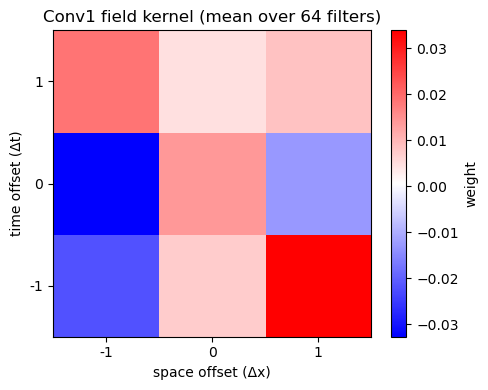

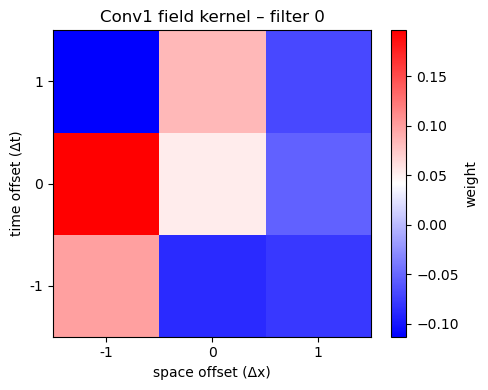

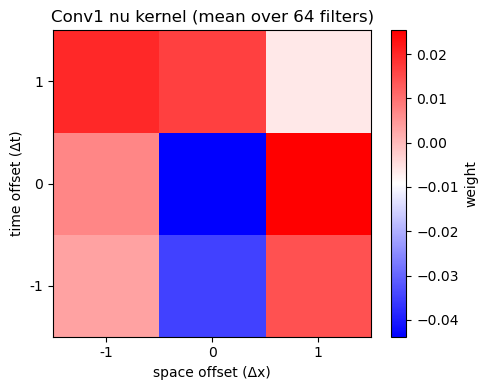

In [ ]:
# Global view: average kernel over all filters, "field" channel
plot_space_time_kernel(model, channel_type="field", out_channel=None)

# To see a specific filter (e.g. filter 0):
plot_space_time_kernel(model, channel_type="field", out_channel=0)

# To see how the model uses ν in the same kernel:
plot_space_time_kernel(model, channel_type="nu", out_channel=None)

### Save Model

In [ ]:
# ========== MODEL SAVING ==========
SAVE_MODEL_NAME = "my_trained_model.pth"  

if SAVE_MODEL_NAME is not None:
    print(f"💾 Saving model to: {SAVE_MODEL_NAME}")
    torch.save(model, models_dir / SAVE_MODEL_NAME)
    print(f"✓ Model saved successfully to: {models_dir / SAVE_MODEL_NAME}")
else:
    print("ℹ️  To save the model, set SAVE_MODEL_NAME = 'filename.pth'")
    print(f"   Models will be saved to: {models_dir}")

💾 Saving model to: my_trained_model.pth
✓ Model saved successfully to: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\saved_models\my_trained_model.pth
